# Example of Kalman Filter decoders

This example is similar to those shown in "Examples_all_decoders."
However, there is some preprocessing is different for the Kalman, so we have made a separate notebook.

In this example notebook, we:
1. Import the necessary packages
2. Load a data file (spike trains and outputs we are predicting)
3. Preprocess the data
4. Run the decoders and print the goodness of fit
5. Plot example decoded outputs

## 1. Import Packages

Below, we import both standard packages, and functions from the accompanying .py files

Note that you may need to specify the path below

In [1]:
## (Configuration) Allows you to return multiple variables from a single cell ##
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [2]:
## Allows you to import files from another folder in current directory ## 
import os 
import sys 
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [3]:
#Import standard packages
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import io
from scipy import stats
import pickle
import sys

#Import metrics
from Neural_Decoding.metrics import get_R2
from Neural_Decoding.metrics import get_rho
from Neural_Decoding.metrics import get_R2_parts

#Import decoder functions
from Neural_Decoding.decoders import KalmanFilterDecoder

## 2. Load Data
The data for this example can be downloaded at this [link](https://www.dropbox.com/s/e9mul73ur9omu5f/example_data_hc.pickle?dl=0).

It is the hc-2 dataset from [crcns](https://crcns.org/data-sets/hc/hc-2). Specifically, we use the dataset "ec014.333" 


The data that we load is in the format described below. We have another example notebook, "Example_format_data_hc", that may be helpful towards putting the data in this format.

Neural data should be a matrix of size "number of time bins" x "number of neurons", where each entry is the firing rate of a given neuron in a given time bin

The output you are decoding should be a matrix of size "number of time bins" x "number of features you are decoding"

In [4]:
# Opening Acc/Dec Data 
folder='/Users/rbhatt6/Documents/MATLAB/' #ENTER THE FOLDER THAT YOUR DATA IS IN

# Decoder Velocity Outputs
with open(folder+'sortInAccDec.pickle','rb') as f:
     sort_In=pickle.load(f,encoding='latin1') 
with open(folder+'sortOutXAccDec.pickle','rb') as f:
     sort_Out_X=pickle.load(f,encoding='latin1') 
with open(folder+'sortOutYAccDec.pickle','rb') as f:
     sort_Out_Y=pickle.load(f,encoding='latin1') 

# Decoder Position Outputs
with open(folder+'sortOutXAccDecPos.pickle','rb') as f:
     sort_Out_X_Pos=pickle.load(f,encoding='latin1') 
with open(folder+'sortOutYAccDecPos.pickle','rb') as f:
     sort_Out_Y_Pos=pickle.load(f,encoding='latin1') 

In [5]:
sort_Out_X[0].shape

(1633, 1)

In [5]:
# Final output is vel, acc, pos
X_Comb_Kin = []
Y_Comb_Kin = []

# Corrected decoder outputs to use (format = x,y vel, x,y acc, x,y pos)
decoder_output = []

for i in range(len(sort_Out_X)):
    # Concatenating vel with acc for X component
    temp1 = (np.diff(sort_Out_X[i], axis = 0))
    temp1 = np.concatenate((temp1,temp1[-1:,:]),axis=0)
    temp1_all_kin = np.array(np.concatenate((sort_Out_X[i], temp1, sort_Out_X_Pos[i]),axis=1))

    temp2 = (np.diff(sort_Out_Y[i], axis = 0))
    temp2 = np.concatenate((temp2,temp2[-1:,:]),axis=0)
    temp2_all_kin = np.array(np.concatenate((sort_Out_Y[i], temp2, sort_Out_Y_Pos[i]),axis=1))
    X_Comb_Kin.append(temp1_all_kin)
    Y_Comb_Kin.append(temp2_all_kin)

    temp3 = np.array(np.concatenate((sort_Out_X[i], sort_Out_Y[i], temp1, temp2, sort_Out_X_Pos[i], sort_Out_Y_Pos[i]),axis=1))

    decoder_output.append(temp3)

y_kf_X = np.array(X_Comb_Kin, dtype=object)
y_kf_Y = np.array(Y_Comb_Kin, dtype=object)

decoder_output[0].shape
len(decoder_output)


(1633, 6)

16

## 3. Preprocess Data

### 3A. User Inputs
The user can define what time period to use spikes from (with respect to the output).

In [6]:
lag=0 #What time bin of spikes should be used relative to the output
#(lag=-1 means use the spikes 1 bin before the output)

### 3B. Format Covariates

### 3C. Take lag into account

In [8]:
num_examples=X_kf.shape[0]

#Re-align data to take lag into account
if lag<0:
    y_kf=y_kf[-lag:,:]
    X_kf=X_kf[0:num_examples+lag,:]
if lag>0:
    y_kf=y_kf[0:num_examples-lag,:]
    X_kf=X_kf[lag:num_examples,:]

NameError: name 'X_kf' is not defined

### 3D. Split into training/testing/validation sets
Note that parameters should be setting using a separate validation set. 
Then, the goodness of fit should be be tested on a testing set (separate from the training and validation sets).

### User Options

In [7]:
#Set what part of data should be part of the training/testing/validation sets
#Note that there was a long period of no movement after about 80% of recording, so I did not use this data.
# training_range=[0, 0.5]
# valid_range=[0.5,0.65]
# testing_range=[0.65, 0.8]

training_range=[0, 0.8]
valid_range=[0.8,0.9]
testing_range=[0.9, 1]

### Split Data: For KF

### 3E. Preprocessing: Normalization and zero-centering
We normalize (z_score) the inputs and zero-center the outputs.
Parameters for z-scoring (mean/std.) should be determined on the training set only, and then these z-scoring parameters are also used on the testing and validation sets.

### Kalman Filter

In [102]:
# Running decoder on X and Y components separately to get X_FVAF and Y_FVAF
from Neural_Decoding.runModelsKF import run_model_kf

Kalman_R2s_X = run_model_kf(sort_In, X_Comb_Kin, training_range, testing_range, valid_range, "score")
Kalman_R2s_Y = run_model_kf(sort_In, Y_Comb_Kin, training_range, testing_range, valid_range, "score")

In [ ]:
Kalman_R2s_X
Kalman_R2s_Y

[array([ 0.30224872,  0.25632642, -0.12978993]),
 array([0.0425781 , 0.27423055, 0.27591032]),
 array([-0.1461146 , -0.06368985, -0.1457565 ]),
 array([0.39496426, 0.31524437, 0.32836486]),
 array([0.56034758, 0.44919384, 0.29546162]),
 array([ 0.38825921,  0.41595144, -0.29051441]),
 array([ 0.03065862,  0.04930176, -0.06618414]),
 array([ 0.29743398,  0.34850001, -0.37983859]),
 array([0.41121539, 0.40715878, 0.15774435]),
 array([0.24786033, 0.25808906, 0.22209676]),
 array([ 0.00573462,  0.00535132, -0.20566142]),
 array([0.11988526, 0.17796593, 0.48312639]),
 array([ 0.22200675,  0.23335033, -0.08170607]),
 array([-0.0088152 ,  0.14507591, -0.17867665]),
 array([-0.08458196, -0.0764017 , -0.39530811]),
 array([0.32957713, 0.31721697, 0.08126852])]

[array([-0.19874973, -0.01997485,  0.31745137]),
 array([0.32887838, 0.31357992, 0.37459851]),
 array([0.55222821, 0.39409203, 0.23105393]),
 array([0.45644956, 0.38173515, 0.29556426]),
 array([0.1524987 , 0.07535192, 0.21384828]),
 array([0.45889071, 0.43608851, 0.42305588]),
 array([0.53123661, 0.46721934, 0.16508487]),
 array([0.38953093, 0.36726555, 0.4885387 ]),
 array([0.10968123, 0.02539443, 0.49808911]),
 array([0.45791102, 0.3244913 , 0.38606927]),
 array([0.56675778, 0.38268575, 0.36105001]),
 array([0.28499669, 0.26845754, 0.31697679]),
 array([0.1918694 , 0.11920303, 0.43227998]),
 array([0.24841163, 0.08270095, 0.37922856]),
 array([0.19540699, 0.26118332, 0.23170832]),
 array([0.20530301, 0.26993926, 0.31053202])]

In [12]:
# Running decoder on X and Y components together to get X_FVAF and Y_FVAF
from Neural_Decoding.runModelsKF import run_model_kf

Kalman_R2s_combined = run_model_kf(sort_In, decoder_output, training_range, testing_range, valid_range, "score")

In [15]:
Kalman_R2s_combined

[array([ 0.30729488, -0.17669232,  0.25707346, -0.02206558, -0.14368645,
         0.33671678]),
 array([0.04923445, 0.36783993, 0.28813384, 0.33552094, 0.28432163,
        0.39124164]),
 array([-0.14479171,  0.5555326 , -0.06771177,  0.39659028, -0.16705605,
         0.23086514]),
 array([0.41535994, 0.46518369, 0.32418706, 0.38273956, 0.33114077,
        0.29517091]),
 array([0.55739155, 0.14328777, 0.44912445, 0.07344649, 0.30002028,
        0.20976833]),
 array([ 0.42045444,  0.46611832,  0.42273348,  0.43524889, -0.29293346,
         0.42711628]),
 array([ 0.02948125,  0.53681293,  0.0475425 ,  0.46801918, -0.0788187 ,
         0.1617549 ]),
 array([ 0.27129203,  0.41350471,  0.35406607,  0.37076093, -0.3756424 ,
         0.49966203]),
 array([0.41628924, 0.10603572, 0.40845273, 0.0240747 , 0.16074472,
        0.49847318]),
 array([0.27542666, 0.44897998, 0.26459784, 0.32644525, 0.23590761,
        0.37736909]),
 array([ 0.00731867,  0.56437816,  0.00776249,  0.38279929, -0.2078184

In [16]:
# Running decoder on X and Y components together to get combined XY_FVAF
from Neural_Decoding.runModelsKF import run_model_kf

Kalman_R2s_XY = run_model_kf(sort_In, decoder_output, training_range, testing_range, valid_range, "parts")


In [17]:
Kalman_R2s_XY[0].shape
range(len(Kalman_R2s_XY))

(2, 6)

range(0, 16)

In [18]:
# Compute combined XY_FVAF (velocity only)
from Neural_Decoding.metrics import compute_XY_FVAF

XY_FVAF = []
for i in range(len(Kalman_R2s_XY)):
    #curr_bucket = Kalman_R2s_combined[i]
    vel_x_nom = Kalman_R2s_XY[i][0][0] # dim = (curr_bucket, nom, x_vel)
    vel_x_denom = Kalman_R2s_XY[i][1][0] # dim = (curr_bucket, denom, x_vel)
    vel_y_nom = Kalman_R2s_XY[i][0][1] # dim = (curr_bucket, nom, y_vel)
    vel_y_denom = Kalman_R2s_XY[i][1][1] # dim = (curr_bucket, denom, y_vel)

    curr_bucket_XY_FVAF = compute_XY_FVAF(vel_x_nom,vel_x_denom,vel_y_nom,vel_y_denom)
    XY_FVAF.append(curr_bucket_XY_FVAF)

XY_FVAF

[0.227405442543961,
 0.17364525033812173,
 0.42608821987503087,
 0.4401308773309419,
 0.4846222047779313,
 0.4384412259646876,
 0.44004068612482317,
 0.34311571051909706,
 0.34949129996278105,
 0.3491056510088656,
 0.3660772407413688,
 0.20775948373460207,
 0.22087696955016312,
 0.1255940498772361,
 0.1417788909949662,
 0.29835663464276874]

In [ ]:
# Determining what y_test, y_test_pred look like in order to get the right nom and denom for R^2

len(Kalman_R2s_XY)

# Iterating through the 16 buckets' validation values
Kalman_R2s_XY[0].shape

# dim1 = 16 buckets, dim2 = y_test or y_test_pred, dim3 = # of validation samples, and dim4 = 6 kinematics 
Kalman_R2s_XY[0][0][0][0]

Kalman_R2s_XY[0][:,0].shape
Kalman_R2s_XY[0][:,0]

In [ ]:
# Testing FVAF calculation on 1st bucket 

y_test = Kalman_R2s_XY[0][0]
y_test.shape
y_test_pred = Kalman_R2s_XY[0][1]
y_test_pred.shape

y_test.shape[1]
range(y_test.shape[1])

# dim = (162,6)
# Want to sum over all samples for each kinematic 
nom_list = []
for i in range(y_test.shape[1]): #Loop through outputs
    #nom = np.sum((y_test_pred[:,i]-y_test[:,i])**2) 
    nom = np.sum((y_test_pred[:,i]-y_test[:,i])**2)
    nom_list.append(nom)

nom.shape 
len(nom_list)
nom_list

In [ ]:
kf_R2s_Y_Comp = []
kf_Rho_Y_Comp = []

for i in range(len(sort_In)):
    X_kf = sort_In[i]
    y_kf = y_kf_Y[i]
    num_examples_kf=X_kf.shape[0] # nRows (b/c nCols = number of units)

    #Note that each range has a buffer of 1 bin at the beginning and end
    #This makes it so that the different sets don't include overlapping data
    training_set=np.arange(int(np.round(training_range[0]*num_examples_kf))+1,int(np.round(training_range[1]*num_examples_kf))-1)
    testing_set=np.arange(int(np.round(testing_range[0]*num_examples_kf))+1,int(np.round(testing_range[1]*num_examples_kf))-1)
    valid_set=np.arange(int(np.round(valid_range[0]*num_examples_kf))+1,int(np.round(valid_range[1]*num_examples_kf))-1)

    #Get training data
    X_kf_train=X_kf[training_set,:]
    y_kf_train=y_kf[training_set,:]

    #Get testing data
    X_kf_test=X_kf[testing_set,:]
    y_kf_test=y_kf[testing_set,:]

    #Get validation data
    X_kf_valid=X_kf[valid_set,:]
    y_kf_valid=y_kf[valid_set,:]

    #Z-score inputs 
    X_kf_train_mean=np.nanmean(X_kf_train,axis=0)
    X_kf_train_std=np.nanstd(X_kf_train,axis=0)
    X_kf_train=(X_kf_train-X_kf_train_mean)/X_kf_train_std
    X_kf_test=(X_kf_test-X_kf_train_mean)/X_kf_train_std
    X_kf_valid=(X_kf_valid-X_kf_train_mean)/X_kf_train_std

    #Zero-center outputs
    y_kf_train_mean=np.mean(y_kf_train,axis=0)
    y_kf_train=y_kf_train-y_kf_train_mean
    y_kf_test=y_kf_test-y_kf_train_mean
    y_kf_valid=y_kf_valid-y_kf_train_mean

    #Declare model
    model_kf=KalmanFilterDecoder(C=1) #There is one optional parameter (see ReadMe)

    #Fit model
    model_kf.fit(X_kf_train,y_kf_train)

    #Get predictions
    y_valid_predicted_kf=model_kf.predict(X_kf_valid,y_kf_valid)

    #Get metrics of fit (see read me for more details on the differences between metrics)
    #First I'll get the R^2
    R2_kf=get_R2_parts(y_kf_valid,y_valid_predicted_kf)
    #print('R2:',R2_kf[0:2]) #I'm just printing the R^2's of the 1st and 2nd entries that correspond to the positions
    kf_R2s_Y_Comp.append(R2_kf)

    #Next I'll get the rho^2 (the pearson correlation squared)
    rho_kf=get_rho(y_kf_valid,y_valid_predicted_kf)
    #print('rho2:',rho_kf[0:2]**2) #I'm just printing the rho^2's of the 1st and 2nd entries that correspond to the positions
    kf_Rho_Y_Comp.append(rho_kf)

In [19]:
# Saving results in a matlab file 

from scipy.io import savemat
import numpy

# L = [kf_R2s_X_Comp, kf_R2s_Y_Comp] # kf_Rho_X_Comp, kf_Rho_Y_Comp
L = [Kalman_R2s_combined, XY_FVAF]

FrameStack = np.empty((2,), dtype=object)
for i in range(len(L)):
    FrameStack[i] = L[i]

savemat("KalmanModelOutputsUpdated.mat", {"KalmanOutputs":FrameStack})

## 5. Make Plots

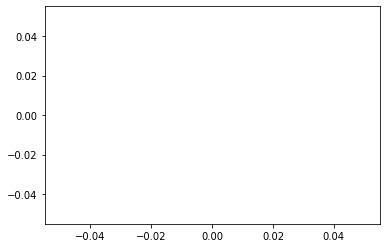

In [ ]:
#As an example, I plot an example 3000 values of the x position (column index 0), both true and predicted with the Kalman filter
#Note that I add back in the mean value, so that both true and predicted values are in the original coordinates
fig_x_kf=plt.figure()
plt.plot(y_kf_valid[2000:5000,0]+y_kf_train_mean[0],'b')
plt.plot(y_valid_predicted_kf[2000:5000,0]+y_kf_train_mean[0],'r')
#Save figure
# fig_x_kf.savefig('x_position_decoding.eps')